# Phase 4: Evaluation Pipeline over Synthetic Data

## 4.0. Path & Model setup

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

BASE_SYN_DIR = Path("../output/synthetic_generation")

# Models
MODEL_INFO = {
    "mixup":  "Mixup",
    "corr":   "Correlation Sampling",
    "wgangp": "WGAN-GP",
    "copula": "Gaussian Copula",
    "interp": "Classwise Interpolation",
}

# Frequency band feature columns
BAND_COLS = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

# Map raw condition strings to clean codes
CONDITION_MAP = {
    "S1 obj": "S1",
    "S2 match": "S2_match",
    "S2 nomatch": "S2_nomatch",
}

CANONICAL_CONDITIONS = ["S1", "S2_match", "S2_nomatch"]

## 4.1 Real vs Synthetic EEG Evaluation

### 4.1.1. Visualization Helper Functions

In [35]:
def visualize_pca_tsne_inline(real_features, synthetic_features, model_name, title_suffix="GLOBAL", max_points=2000):
    if len(real_features) < 10 or len(synthetic_features) < 10:
        print(f"Not enough samples for {model_name} [{title_suffix}] — skipping…")
        return
    
    # Subsample
    n_sub = min(max_points, len(real_features), len(synthetic_features))
    idx_real = np.random.choice(len(real_features), n_sub, replace=False)
    idx_syn  = np.random.choice(len(synthetic_features), n_sub, replace=False)

    X_real = real_features[idx_real]
    X_syn  = synthetic_features[idx_syn]

    X = np.vstack([X_real, X_syn])
    y = np.array(["Real"] * n_sub + ["Synthetic"] * n_sub)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # TSNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, max(5, n_sub // 5)),
        random_state=42,
        init="pca",
        learning_rate="auto",
    )
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
        alpha=0.5, s=12, ax=axes[0], edgecolor=None
    )
    axes[0].set_title(f"PCA – {model_name} [{title_suffix}]")

    sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y,
        alpha=0.5, s=12, ax=axes[1], edgecolor=None, legend=False
    )
    axes[1].set_title(f"t-SNE – {model_name} [{title_suffix}]")

    plt.tight_layout()
    plt.show()

### 4.1.2. KS and MMD Helper Functions

In [ ]:
def evaluate_distribution_metrics(real_features, synthetic_features, model_name, title_suffix="GLOBAL"):
    print(f"DISTRIBUTION METRICS — {model_name} [{title_suffix}]")

    ks_results = []
    for i, band in enumerate(BAND_COLS):
        ks_stat, p = ks_2samp(real_features[:, i], synthetic_features[:, i])
        flag = "✓ Similar" if p > 0.05 else "✗ Different"
        print(f"{band:8s}: KS={ks_stat:.4f}, p={p:.4f}   {flag}")
        ks_results.append((band, ks_stat, p))

    # Subsample MMD
    n = min(1000, len(real_features), len(synthetic_features))
    X = real_features[:n]
    Y = synthetic_features[:n]

    XX = cdist(X, X)
    YY = cdist(Y, Y)
    XY = cdist(X, Y)

    mmd = XX.mean() + YY.mean() - 2 * XY.mean()

    print(f"MMD: {mmd:.6f}")
    return ks_results, mmd

### 4.1.3. Real vs Synthetic Classification Helper Functions

In [ ]:
def evaluate_real_vs_syn(real_X, syn_X, model_name, title_suffix="GLOBAL"):
    print(f"REAL-vs-SYN CLASSIFIER — {model_name} [{title_suffix}]")

    X = np.vstack([real_X, syn_X])
    y = np.concatenate([np.ones(len(real_X)), np.zeros(len(syn_X))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("Accuracy:", round(acc, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return acc

### 4.1.4. TSTR VS. TRTR Helper Functions

In [38]:
def evaluate_tstr_trtr(real_X, real_y, syn_X, syn_y, model_name, title_suffix="GLOBAL"):
    print(f"TSTR / TRTR — {model_name} [{title_suffix}]")

    # Train on real
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        real_X, real_y, test_size=0.3, random_state=42
    )

    # TRTR
    clf_real = RandomForestClassifier(n_estimators=200, random_state=42)
    clf_real.fit(X_train_real, y_train_real)
    acc_trtr = clf_real.score(X_test_real, y_test_real)

    # Match synthetic data to real train size
    syn_X_trim = syn_X[:len(y_train_real)]
    syn_y_trim = syn_y[:len(y_train_real)]

    # TSTR
    clf_syn = RandomForestClassifier(n_estimators=200, random_state=42)
    clf_syn.fit(syn_X_trim, syn_y_trim)
    acc_tstr = clf_syn.score(X_test_real, y_test_real)

    gap = abs(acc_trtr - acc_tstr)

    print(f"TRTR: {acc_trtr:.4f}")
    print(f"TSTR: {acc_tstr:.4f}")
    print(f"Gap : {gap:.4f}")

    return acc_trtr, acc_tstr, gap

### 4.1.5. Condition-conditional Evaluation Functions

In [ ]:
def evaluate_condition(real_X, real_y, real_c, syn_X, syn_y, syn_c, model_name, cond):
    print(f"CONDITION {cond} — {model_name}")

    mask_r = (real_c == cond)
    mask_s = (syn_c == cond)

    if mask_r.sum() < 50 or mask_s.sum() < 50:
        print(f"[Skip] Not enough samples for {cond}: real={mask_r.sum()}, syn={mask_s.sum()}")
        return None

    Xr = real_X[mask_r]
    yr = real_y[mask_r]
    Xs = syn_X[mask_s]
    ys = syn_y[mask_s]

    # Visualization
    visualize_pca_tsne_inline(Xr, Xs, model_name, cond)

    # KS + MMD
    ks, mmd = evaluate_distribution_metrics(Xr, Xs, model_name, cond)

    # Real-vs-Syn classifier
    acc = evaluate_real_vs_syn(Xr, Xs, model_name, cond)

    # TSTR/TRTR
    trtr, tstr, gap = evaluate_tstr_trtr(Xr, yr, Xs, ys, model_name, cond)

    return {
        "ks": ks,
        "mmd": mmd,
        "rvs_acc": acc,
        "trtr": trtr,
        "tstr": tstr,
        "gap": gap,
        "N_real": mask_r.sum(),
        "N_syn": mask_s.sum(),
    }

### 4.1.6. Master Function for Synthetic EEG Evaluation of Each Model

In [ ]:
def evaluate_model_step_by_step(model_key):
    model_name = MODEL_INFO[model_key]
    print(f"EVALUATING MODEL: {model_name} ({model_key})")

    # Load
    real_X, real_y, real_c, syn_X, syn_y, syn_c = load_model_data(model_key)

    # GLOBAL VISUALIZATION
    visualize_pca_tsne_inline(real_X, syn_X, model_name, "GLOBAL")

    # GLOBAL METRICS
    ks, mmd = evaluate_distribution_metrics(real_X, syn_X, model_name, "GLOBAL")
    rvs_acc = evaluate_real_vs_syn(real_X, syn_X, model_name, "GLOBAL")
    trtr, tstr, gap = evaluate_tstr_trtr(real_X, real_y, syn_X, syn_y, model_name, "GLOBAL")

    global_results = {
        "ks": ks,
        "mmd": mmd,
        "rvs_acc": rvs_acc,
        "trtr": trtr,
        "tstr": tstr,
        "gap": gap,
    }

    # CONDITION-COND EVALUATION
    cond_results = {}
    for cond in CANONICAL_CONDITIONS:
        res = evaluate_condition(
            real_X, real_y, real_c,
            syn_X, syn_y, syn_c,
            model_name, cond
        )
        cond_results[cond] = res

    return {
        "global": global_results,
        "condition": cond_results,
    }

## 4.2. Each Synthetic Evaluation from Models

### 4.2.1. Mixup Baseline Model Evaluation

EVALUATING MODEL: Mixup (mixup)


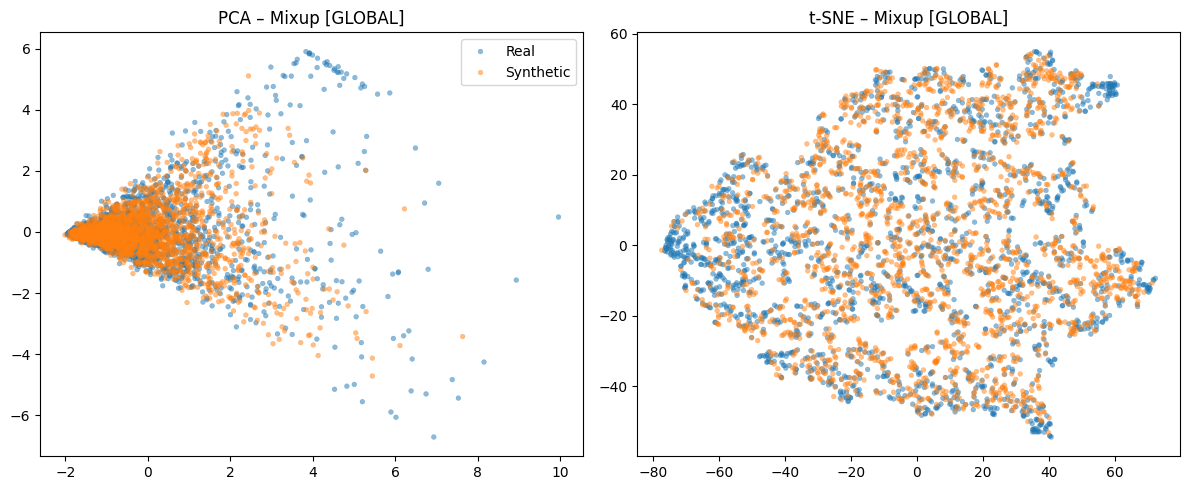

DISTRIBUTION METRICS — Mixup [GLOBAL]
Delta   : KS=0.1381, p=0.0000   ✗ Different
Theta   : KS=0.1263, p=0.0000   ✗ Different
Alpha   : KS=0.1324, p=0.0000   ✗ Different
Beta    : KS=0.1212, p=0.0000   ✗ Different
Gamma   : KS=0.1361, p=0.0000   ✗ Different
MMD: -0.343235
REAL-vs-SYN CLASSIFIER — Mixup [GLOBAL]
Accuracy: 0.6879
Confusion Matrix:
 [[6655 2508]
 [3173 5866]]
TSTR / TRTR — Mixup [GLOBAL]
TRTR: 0.7527
TSTR: 0.4828
Gap : 0.2699
CONDITION S1 — Mixup


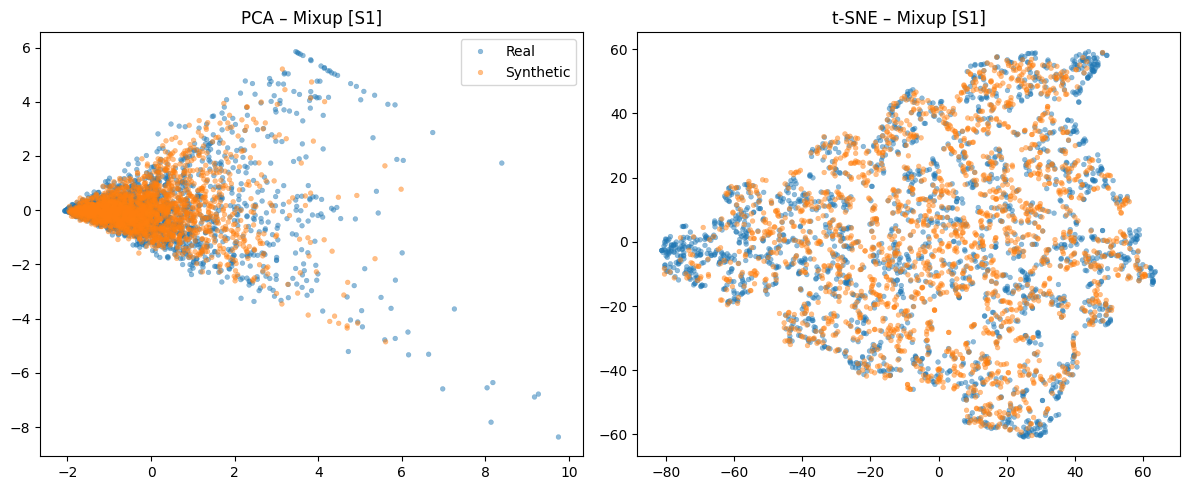

DISTRIBUTION METRICS — Mixup [S1]
Delta   : KS=0.1423, p=0.0000   ✗ Different
Theta   : KS=0.1263, p=0.0000   ✗ Different
Alpha   : KS=0.1357, p=0.0000   ✗ Different
Beta    : KS=0.1239, p=0.0000   ✗ Different
Gamma   : KS=0.1388, p=0.0000   ✗ Different
MMD: -0.287355
REAL-vs-SYN CLASSIFIER — Mixup [S1]
Accuracy: 0.6779
Confusion Matrix:
 [[2245  832]
 [1147 1920]]
TSTR / TRTR — Mixup [S1]
TRTR: 0.7122
TSTR: 0.4645
Gap : 0.2477
CONDITION S2_match — Mixup


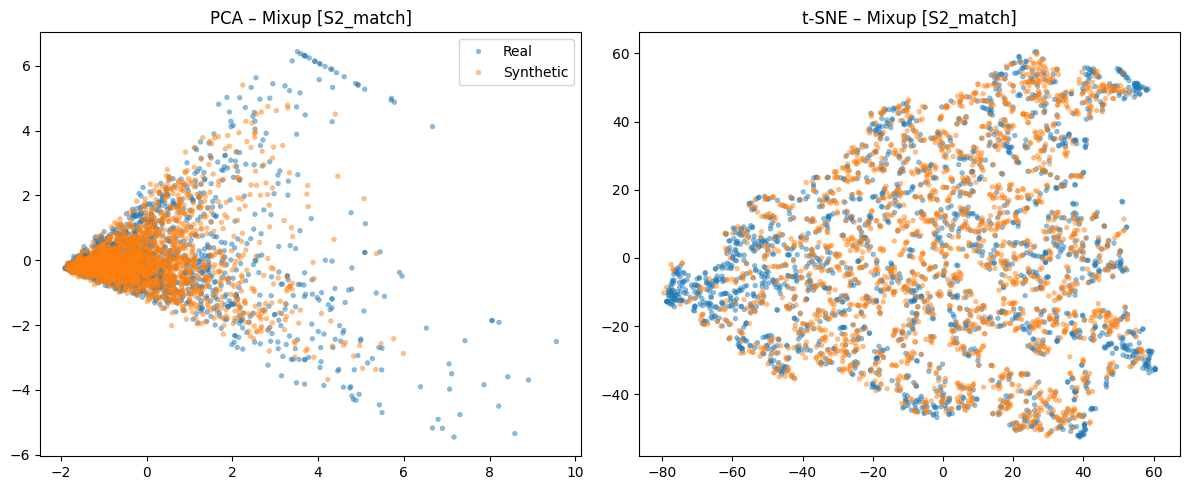

DISTRIBUTION METRICS — Mixup [S2_match]
Delta   : KS=0.1394, p=0.0000   ✗ Different
Theta   : KS=0.1279, p=0.0000   ✗ Different
Alpha   : KS=0.1370, p=0.0000   ✗ Different
Beta    : KS=0.1268, p=0.0000   ✗ Different
Gamma   : KS=0.1349, p=0.0000   ✗ Different
MMD: -0.208404
REAL-vs-SYN CLASSIFIER — Mixup [S2_match]
Accuracy: 0.7134
Confusion Matrix:
 [[2245  772]
 [ 978 2111]]
TSTR / TRTR — Mixup [S2_match]
TRTR: 0.7986
TSTR: 0.5080
Gap : 0.2905
CONDITION S2_nomatch — Mixup
[Skip] Not enough samples for S2_nomatch: real=0, syn=0


In [41]:
mixup_results = evaluate_model_step_by_step("mixup")

### 4.2.2. Correlation Sampling Model Evaluation

EVALUATING MODEL: Correlation Sampling (corr)


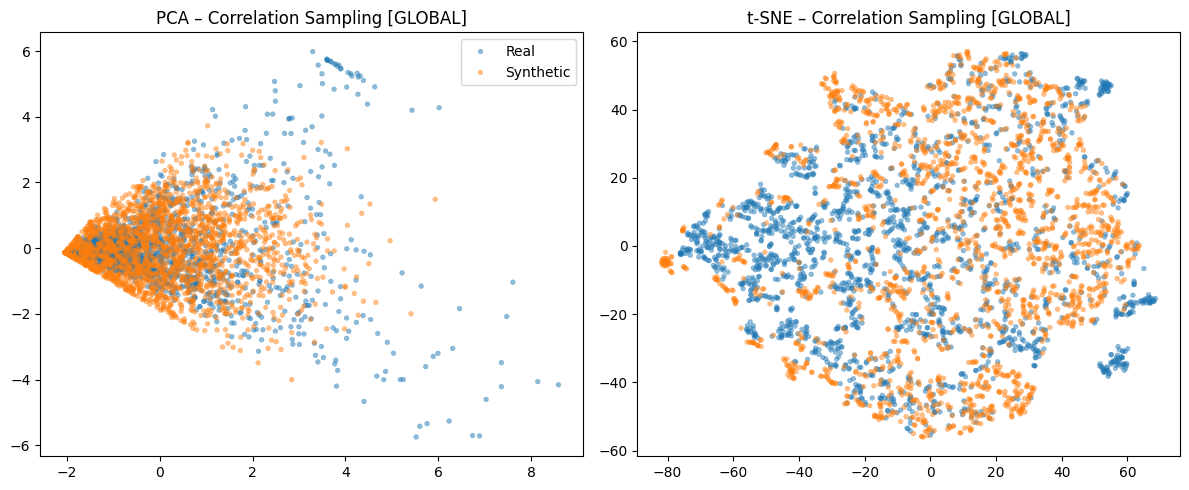

DISTRIBUTION METRICS — Correlation Sampling [GLOBAL]
Delta   : KS=0.2536, p=0.0000   ✗ Different
Theta   : KS=0.2176, p=0.0000   ✗ Different
Alpha   : KS=0.2360, p=0.0000   ✗ Different
Beta    : KS=0.1644, p=0.0000   ✗ Different
Gamma   : KS=0.2495, p=0.0000   ✗ Different
MMD: -0.428586
REAL-vs-SYN CLASSIFIER — Correlation Sampling [GLOBAL]
Accuracy: 0.8977
Confusion Matrix:
 [[8071 1092]
 [ 770 8269]]
TSTR / TRTR — Correlation Sampling [GLOBAL]
TRTR: 0.7527
TSTR: 0.4913
Gap : 0.2614
CONDITION S1 — Correlation Sampling


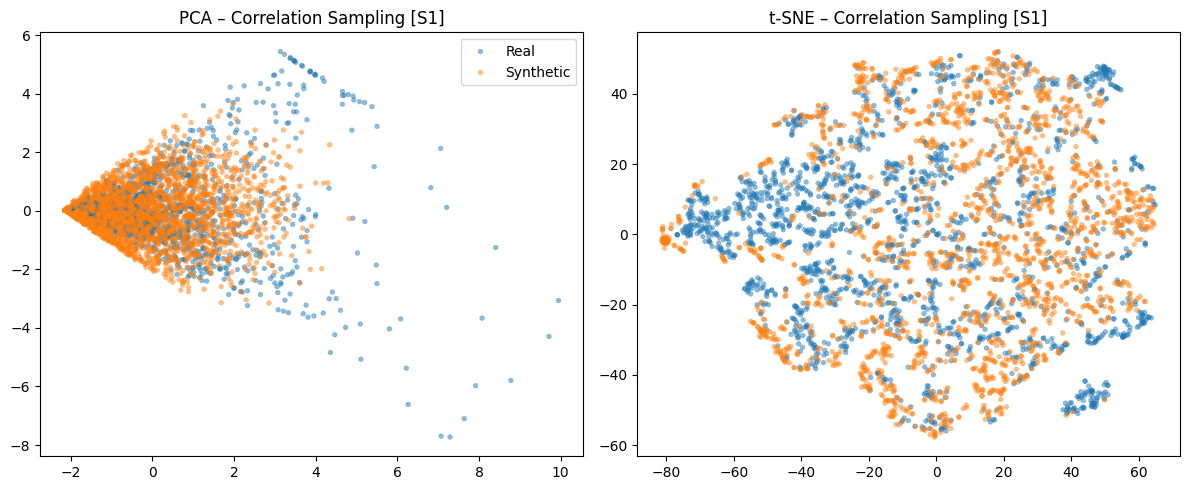

DISTRIBUTION METRICS — Correlation Sampling [S1]
Delta   : KS=0.2378, p=0.0000   ✗ Different
Theta   : KS=0.2174, p=0.0000   ✗ Different
Alpha   : KS=0.2232, p=0.0000   ✗ Different
Beta    : KS=0.1495, p=0.0000   ✗ Different
Gamma   : KS=0.2487, p=0.0000   ✗ Different
MMD: -0.371892
REAL-vs-SYN CLASSIFIER — Correlation Sampling [S1]
Accuracy: 0.8856
Confusion Matrix:
 [[2686  391]
 [ 312 2755]]
TSTR / TRTR — Correlation Sampling [S1]
TRTR: 0.7122
TSTR: 0.5124
Gap : 0.1999
CONDITION S2_match — Correlation Sampling


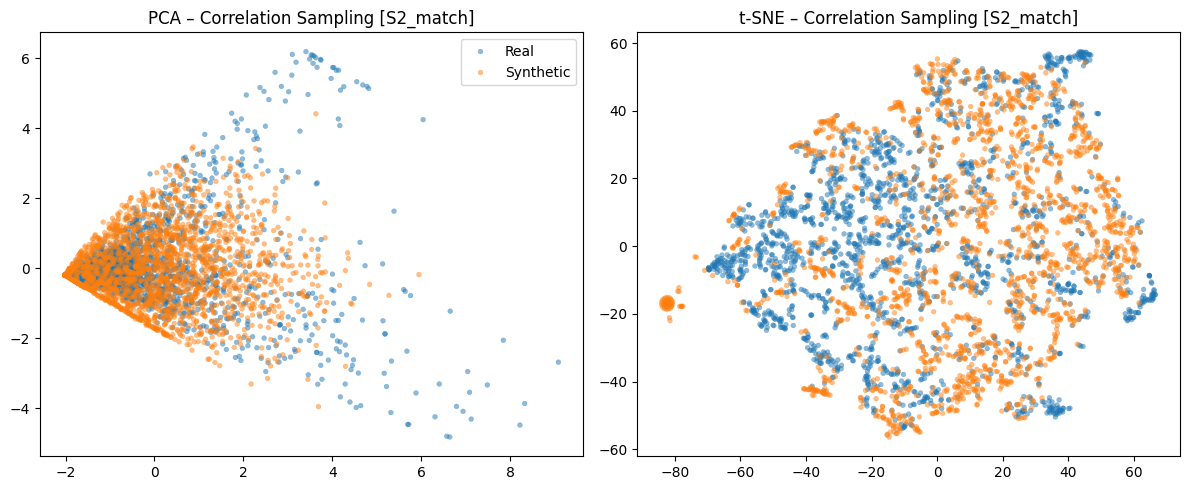

DISTRIBUTION METRICS — Correlation Sampling [S2_match]
Delta   : KS=0.2657, p=0.0000   ✗ Different
Theta   : KS=0.2222, p=0.0000   ✗ Different
Alpha   : KS=0.2566, p=0.0000   ✗ Different
Beta    : KS=0.1676, p=0.0000   ✗ Different
Gamma   : KS=0.2495, p=0.0000   ✗ Different
MMD: -0.398181
REAL-vs-SYN CLASSIFIER — Correlation Sampling [S2_match]
Accuracy: 0.9114
Confusion Matrix:
 [[2704  313]
 [ 228 2861]]
TSTR / TRTR — Correlation Sampling [S2_match]
TRTR: 0.7986
TSTR: 0.4874
Gap : 0.3112
CONDITION S2_nomatch — Correlation Sampling
[Skip] Not enough samples for S2_nomatch: real=0, syn=0


In [42]:
corr_results = evaluate_model_step_by_step("corr")

### 4.2.3. WGAN-GP Model Evaluation

EVALUATING MODEL: WGAN-GP (wgangp)


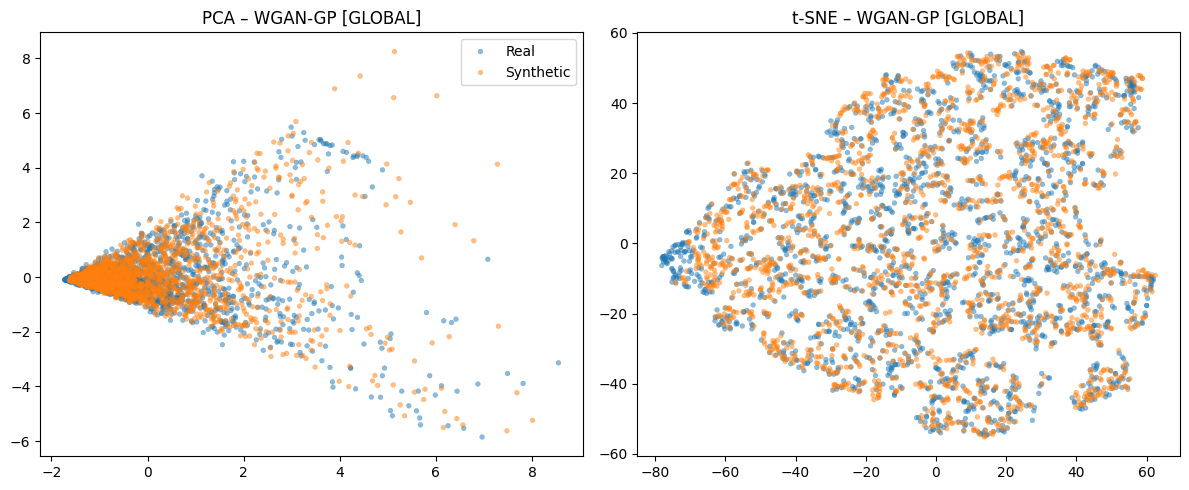

DISTRIBUTION METRICS — WGAN-GP [GLOBAL]
Delta   : KS=0.0138, p=0.0059   ✗ Different
Theta   : KS=0.0409, p=0.0000   ✗ Different
Alpha   : KS=0.0275, p=0.0000   ✗ Different
Beta    : KS=0.0315, p=0.0000   ✗ Different
Gamma   : KS=0.0480, p=0.0000   ✗ Different
MMD: -0.241229
REAL-vs-SYN CLASSIFIER — WGAN-GP [GLOBAL]
Accuracy: 0.6598
Confusion Matrix:
 [[5904 3259]
 [2933 6106]]
TSTR / TRTR — WGAN-GP [GLOBAL]
TRTR: 0.7527
TSTR: 0.5036
Gap : 0.2491
CONDITION S1 — WGAN-GP


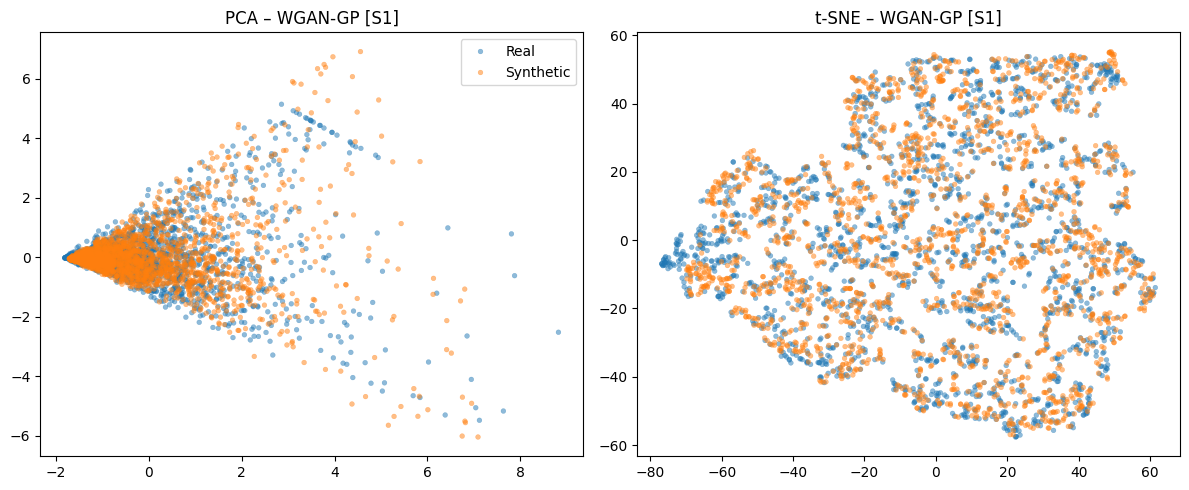

DISTRIBUTION METRICS — WGAN-GP [S1]
Delta   : KS=0.0511, p=0.0000   ✗ Different
Theta   : KS=0.0456, p=0.0000   ✗ Different
Alpha   : KS=0.0268, p=0.0013   ✗ Different
Beta    : KS=0.0220, p=0.0140   ✗ Different
Gamma   : KS=0.0291, p=0.0003   ✗ Different
MMD: -0.176048
REAL-vs-SYN CLASSIFIER — WGAN-GP [S1]
Accuracy: 0.6698
Confusion Matrix:
 [[2127  950]
 [1079 1988]]
TSTR / TRTR — WGAN-GP [S1]
TRTR: 0.7122
TSTR: 0.5114
Gap : 0.2008
CONDITION S2_match — WGAN-GP


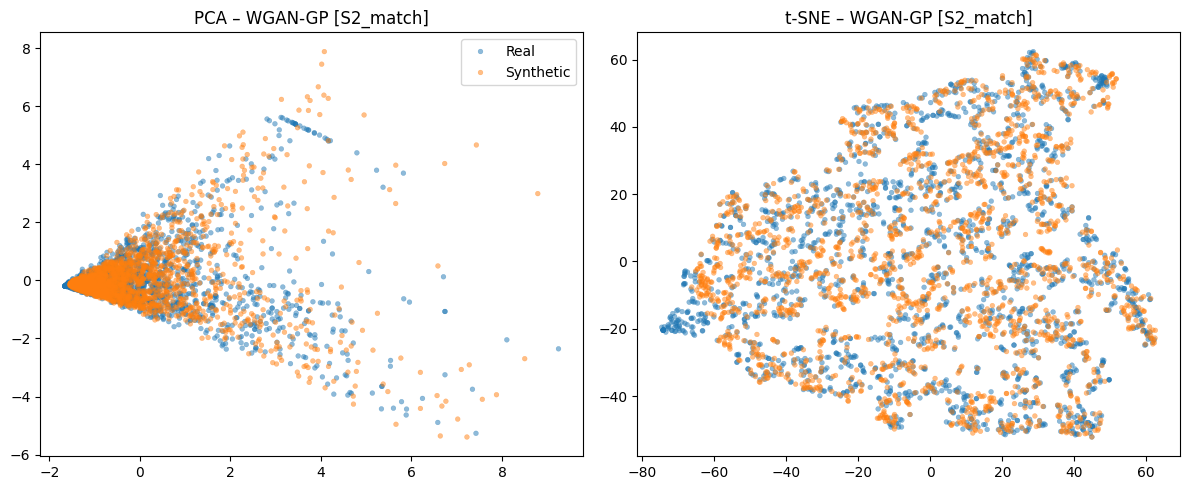

DISTRIBUTION METRICS — WGAN-GP [S2_match]
Delta   : KS=0.0256, p=0.0024   ✗ Different
Theta   : KS=0.0505, p=0.0000   ✗ Different
Alpha   : KS=0.0176, p=0.0848   ✓ Similar
Beta    : KS=0.0540, p=0.0000   ✗ Different
Gamma   : KS=0.0807, p=0.0000   ✗ Different
MMD: -0.128904
REAL-vs-SYN CLASSIFIER — WGAN-GP [S2_match]
Accuracy: 0.7447
Confusion Matrix:
 [[2275  742]
 [ 817 2272]]
TSTR / TRTR — WGAN-GP [S2_match]
TRTR: 0.7986
TSTR: 0.4946
Gap : 0.3040
CONDITION S2_nomatch — WGAN-GP
[Skip] Not enough samples for S2_nomatch: real=0, syn=0


In [43]:
wgangp_results = evaluate_model_step_by_step("wgangp")

### 4.2.4. Gaussian Copula Sampling Model Evaluation

EVALUATING MODEL: Gaussian Copula (copula)


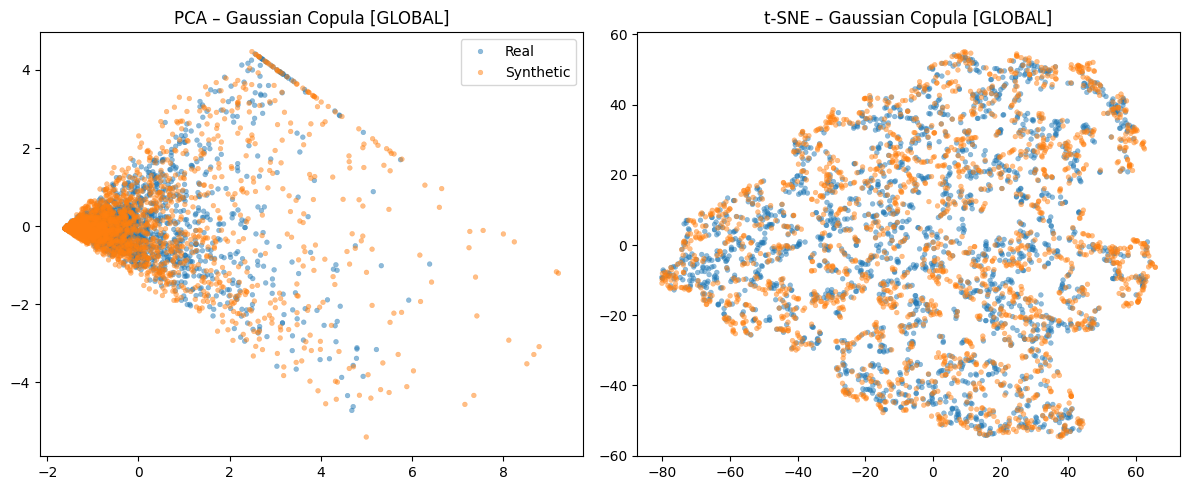

DISTRIBUTION METRICS — Gaussian Copula [GLOBAL]
Delta   : KS=0.0546, p=0.0000   ✗ Different
Theta   : KS=0.0476, p=0.0000   ✗ Different
Alpha   : KS=0.0443, p=0.0000   ✗ Different
Beta    : KS=0.0560, p=0.0000   ✗ Different
Gamma   : KS=0.0541, p=0.0000   ✗ Different
MMD: -0.267701
REAL-vs-SYN CLASSIFIER — Gaussian Copula [GLOBAL]
Accuracy: 0.6537
Confusion Matrix:
 [[5373 3790]
 [2514 6525]]
TSTR / TRTR — Gaussian Copula [GLOBAL]
TRTR: 0.7527
TSTR: 0.6815
Gap : 0.0712
CONDITION S1 — Gaussian Copula


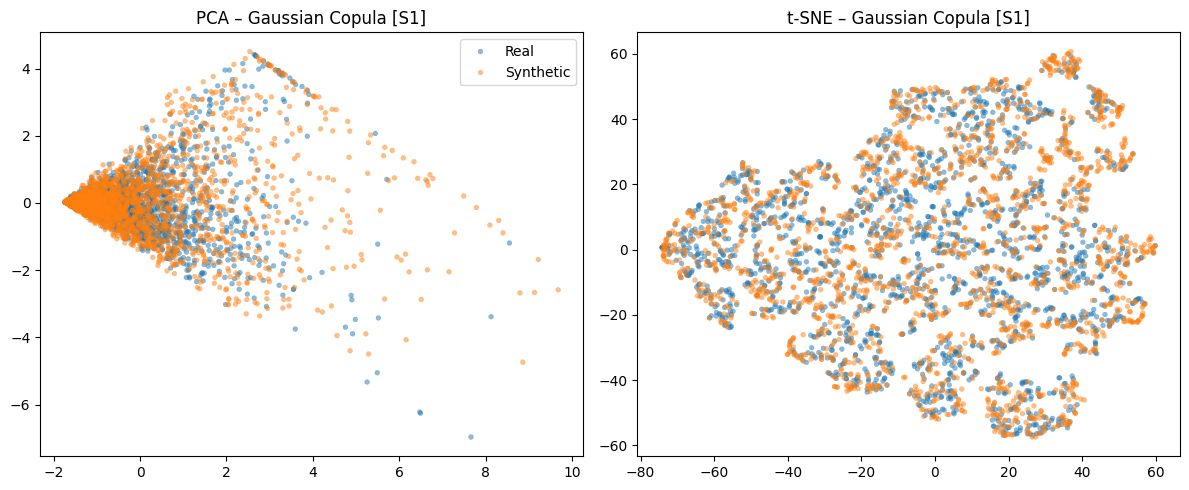

DISTRIBUTION METRICS — Gaussian Copula [S1]
Delta   : KS=0.0451, p=0.0000   ✗ Different
Theta   : KS=0.0484, p=0.0000   ✗ Different
Alpha   : KS=0.0369, p=0.0000   ✗ Different
Beta    : KS=0.0678, p=0.0000   ✗ Different
Gamma   : KS=0.0620, p=0.0000   ✗ Different
MMD: -0.202198
REAL-vs-SYN CLASSIFIER — Gaussian Copula [S1]
Accuracy: 0.6257
Confusion Matrix:
 [[1765 1312]
 [ 988 2079]]
TSTR / TRTR — Gaussian Copula [S1]
TRTR: 0.7122
TSTR: 0.6676
Gap : 0.0446
CONDITION S2_match — Gaussian Copula


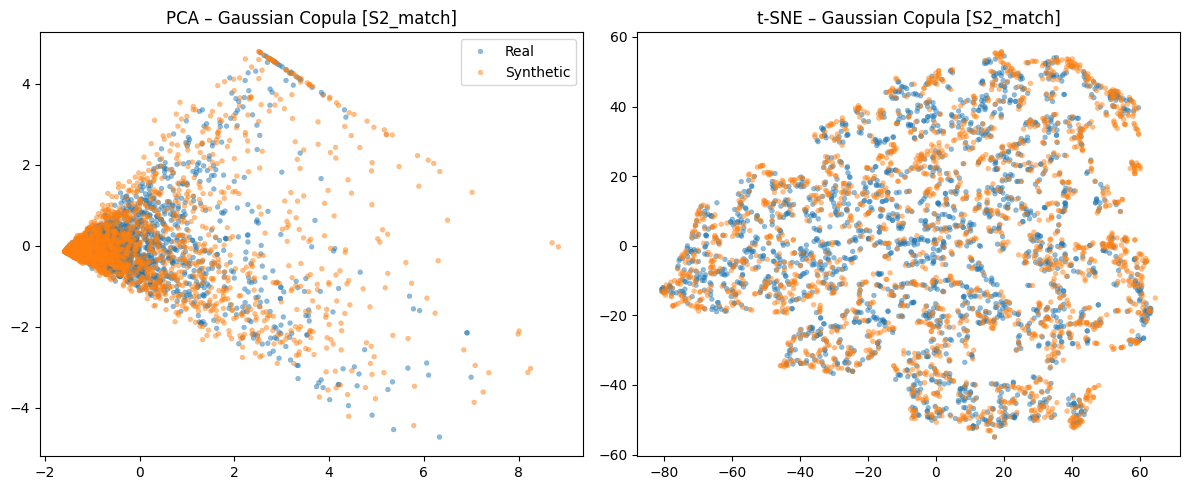

DISTRIBUTION METRICS — Gaussian Copula [S2_match]
Delta   : KS=0.0735, p=0.0000   ✗ Different
Theta   : KS=0.0614, p=0.0000   ✗ Different
Alpha   : KS=0.0648, p=0.0000   ✗ Different
Beta    : KS=0.0530, p=0.0000   ✗ Different
Gamma   : KS=0.0472, p=0.0000   ✗ Different
MMD: -0.220637
REAL-vs-SYN CLASSIFIER — Gaussian Copula [S2_match]
Accuracy: 0.6728
Confusion Matrix:
 [[1884 1133]
 [ 865 2224]]
TSTR / TRTR — Gaussian Copula [S2_match]
TRTR: 0.7986
TSTR: 0.7082
Gap : 0.0904
CONDITION S2_nomatch — Gaussian Copula
[Skip] Not enough samples for S2_nomatch: real=0, syn=0


In [44]:
copula_results = evaluate_model_step_by_step("copula")

### 4.2.5. Classwise Interpolation Model Evaluation

EVALUATING MODEL: Classwise Interpolation (interp)


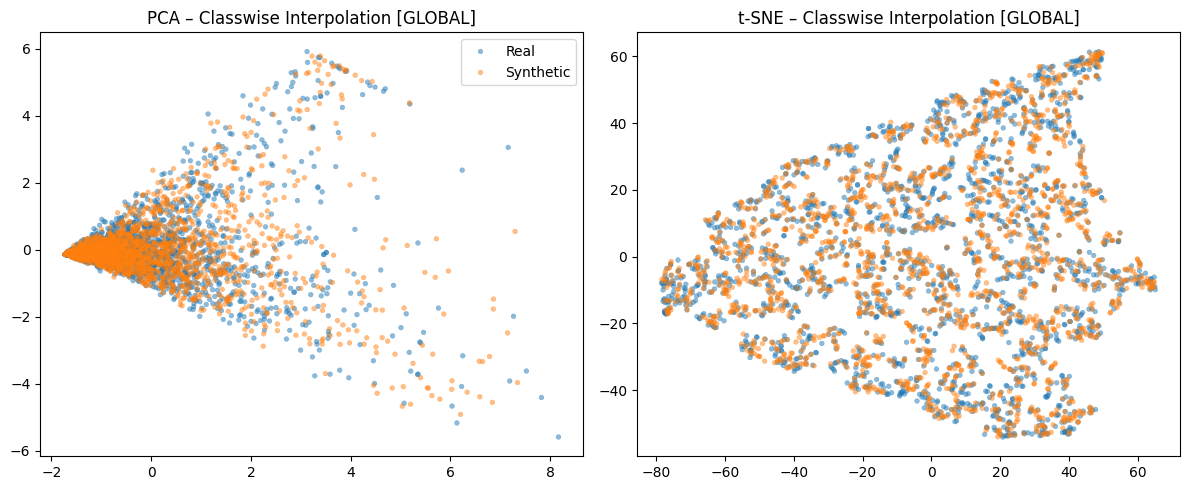

DISTRIBUTION METRICS — Classwise Interpolation [GLOBAL]
Delta   : KS=0.0089, p=0.1765   ✓ Similar
Theta   : KS=0.0101, p=0.0907   ✓ Similar
Alpha   : KS=0.0084, p=0.2289   ✓ Similar
Beta    : KS=0.0119, p=0.0277   ✗ Different
Gamma   : KS=0.0129, p=0.0125   ✗ Different
MMD: -0.248633
REAL-vs-SYN CLASSIFIER — Classwise Interpolation [GLOBAL]
Accuracy: 0.5083
Confusion Matrix:
 [[5029 4134]
 [4816 4223]]
TSTR / TRTR — Classwise Interpolation [GLOBAL]
TRTR: 0.7527
TSTR: 0.7917
Gap : 0.0390
CONDITION S1 — Classwise Interpolation


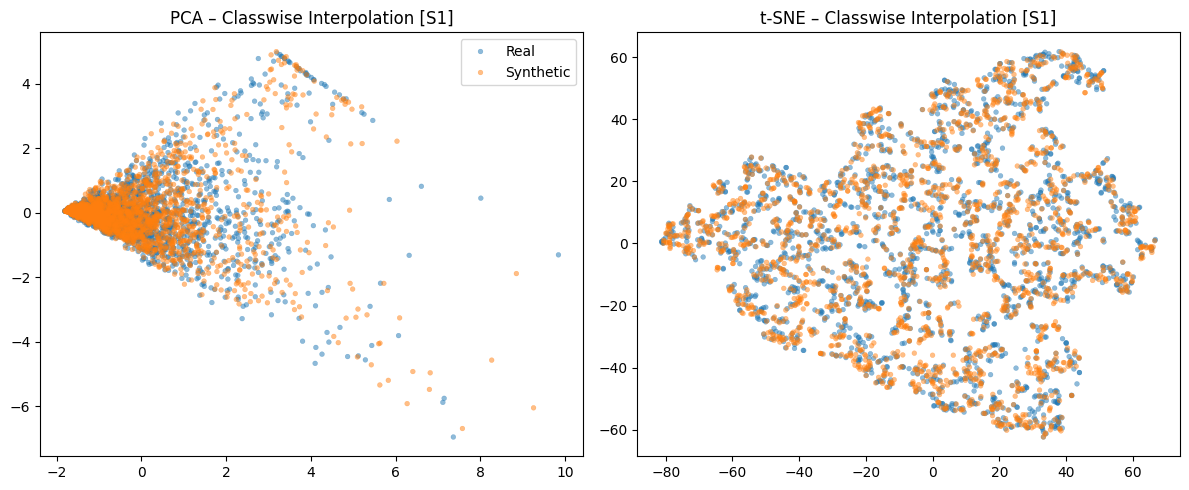

DISTRIBUTION METRICS — Classwise Interpolation [S1]
Delta   : KS=0.0093, p=0.7666   ✓ Similar
Theta   : KS=0.0123, p=0.4170   ✓ Similar
Alpha   : KS=0.0100, p=0.6860   ✓ Similar
Beta    : KS=0.0142, p=0.2537   ✓ Similar
Gamma   : KS=0.0254, p=0.0027   ✗ Different
MMD: -0.205496
REAL-vs-SYN CLASSIFIER — Classwise Interpolation [S1]
Accuracy: 0.4557
Confusion Matrix:
 [[1523 1554]
 [1790 1277]]
TSTR / TRTR — Classwise Interpolation [S1]
TRTR: 0.7122
TSTR: 0.7887
Gap : 0.0765
CONDITION S2_match — Classwise Interpolation


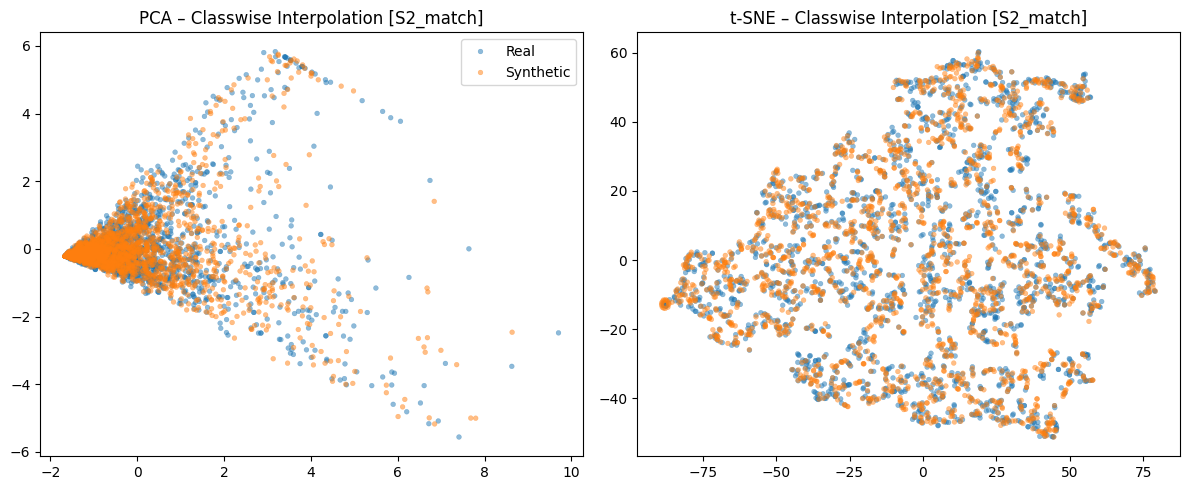

DISTRIBUTION METRICS — Classwise Interpolation [S2_match]
Delta   : KS=0.0131, p=0.3467   ✓ Similar
Theta   : KS=0.0101, p=0.6705   ✓ Similar
Alpha   : KS=0.0108, p=0.5880   ✓ Similar
Beta    : KS=0.0100, p=0.6823   ✓ Similar
Gamma   : KS=0.0180, p=0.0735   ✓ Similar
MMD: -0.126825
REAL-vs-SYN CLASSIFIER — Classwise Interpolation [S2_match]
Accuracy: 0.5029
Confusion Matrix:
 [[1604 1413]
 [1622 1467]]
TSTR / TRTR — Classwise Interpolation [S2_match]
TRTR: 0.7986
TSTR: 0.8290
Gap : 0.0305
CONDITION S2_nomatch — Classwise Interpolation
[Skip] Not enough samples for S2_nomatch: real=0, syn=0


In [46]:
interp_results = evaluate_model_step_by_step("interp")

In [27]:
rows = []
for key, res in all_eval_results.items():
    rows.append({
        "Model Key": key,
        "Model Name": res["name"],
        "MMD (global)": res["mmd_global"],
        "Real-vs-Syn Acc (global)": res["rvs_acc_global"],
        "TRTR (global)": res["trtr_global"],
        "TSTR (global)": res["tstr_global"],
        "Gap (TRTR - TSTR)": res["gap_global"],
    })

summary_df = pd.DataFrame(rows)
summary_df.sort_values("Gap (TRTR - TSTR)", inplace=True)
summary_df

Model Key               Model Name  MMD (global)  Real-vs-Syn Acc (global)  \
0     mixup                    Mixup     -0.036481                  0.687891   
4    interp  Classwise Interpolation     -0.000829                  0.508296   
2    wgangp                  WGAN-GP     -0.001119                  0.659818   
3    copula          Gaussian Copula     -0.042084                  0.653664   
1      corr     Correlation Sampling     -0.131597                  0.897704   

   TRTR (global)  TSTR (global)  Gap (TRTR - TSTR)  
0       0.752665       0.521371           0.231293  
4       0.752665       0.511702           0.240963  
2       0.752665       0.504890           0.247775  
3       0.752665       0.489836           0.262828  
1       0.752665       0.483134           0.269531

In [28]:
cond_rows = []
for key, res in all_eval_results.items():
    for cond, cres in res["condition_results"].items():
        cond_rows.append({
            "Model Key": key,
            "Model Name": res["name"],
            "Condition": cond,
            "MMD": cres["mmd"],
            "Real-vs-Syn Acc": cres["real_vs_syn_acc"],
            "TRTR": cres["trtr"],
            "TSTR": cres["tstr"],
            "Gap": cres["gap"],
            "N_real": cres["n_real"],
            "N_syn": cres["n_syn"],
        })

cond_summary_df = pd.DataFrame(cond_rows)
cond_summary_df

Model Key               Model Name   Condition       MMD  Real-vs-Syn Acc  \
0      mixup                    Mixup          S1 -0.038782         0.677897   
1      mixup                    Mixup    S2_match -0.037405         0.713397   
2      mixup                    Mixup  S2_nomatch -0.036371         0.685148   
3       corr     Correlation Sampling          S1 -0.111402         0.885579   
4       corr     Correlation Sampling    S2_match -0.152171         0.911399   
5       corr     Correlation Sampling  S2_nomatch -0.141357         0.901546   
6     wgangp                  WGAN-GP          S1 -0.001858         0.669759   
7     wgangp                  WGAN-GP    S2_match -0.003001         0.744677   
8     wgangp                  WGAN-GP  S2_nomatch -0.003842         0.701445   
9     copula          Gaussian Copula          S1 -0.038860         0.625651   
10    copula          Gaussian Copula    S2_match -0.045697         0.672781   
11    copula          Gaussian Copula  S2_nomatch -0.048256         0.654234   
12    interp  Classwise Interpolation          S1 -0.001091         0.455729   
13    interp  Classwise Interpolation    S2_match -0.000516         0.502948   
14    interp  Classwise Interpolation  S2_nomatch -0.001366         0.491095   

        TRTR      TSTR       Gap  N_real  N_syn  
0   0.712240  0.497396  0.214844   10240  10240  
1   0.798559  0.522437  0.276122   10176  10176  
2   0.771505  0.532258  0.239247    9920   9920  
3   0.712240  0.501953  0.210286   10240  10240  
4   0.798559  0.453652  0.344907   10176  10176  
5   0.771505  0.477487  0.294019    9920   9920  
6   0.712240  0.513346  0.198893   10240  10240  
7   0.798559  0.512283  0.286276   10176  10176  
8   0.771505  0.492272  0.279234    9920   9920  
9   0.712240  0.498698  0.213542   10240  10240  
10  0.798559  0.518834  0.279725   10176  10176  
11  0.771505  0.483535  0.287970    9920   9920  
12  0.712240  0.487630  0.224609   10240  10240  
13  0.798559  0.509663  0.288896   10176  10176  
14  0.771505  0.504032  0.267473    9920   9920

In [ ]:
# Pivot: rows = model, cols = condition, values = Gap
gap_pivot = cond_summary_df.pivot_table(
    index="Model Name",
    columns="Condition",
    values="Gap"
).reindex(["Mixup", "Correlation Sampling", "WGAN-GP", "Gaussian Copula", "Classwise Interpolation"])

plt.figure(figsize=(7, 4))
sns.heatmap(gap_pivot, annot=True, fmt=".3f", cmap="viridis_r")
plt.title("TSTR Gap (|TRTR - TSTR|) per Model × Condition")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "heatmap_tstr_gap_per_condition.png", dpi=200)
plt.close()

In [32]:
# Build a tidy df from all_eval_results global ks
ks_rows = []
for key, res in all_eval_results.items():
    model_name = res["name"]
    for entry in res["ks_global"]:  # assuming you store 'ks_global' like earlier
        ks_rows.append({
            "Model Name": model_name,
            "Band": entry["band"],
            "KS": entry["ks_stat"],
            "p_value": entry["p_value"],
        })

ks_df = pd.DataFrame(ks_rows)

plt.figure(figsize=(8, 4))
sns.barplot(data=ks_df, x="Band", y="KS", hue="Model Name")
plt.title("KS Distance per Band per Model (Global)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "ks_per_band_global.png", dpi=200)
plt.close()


In [2]:
import json
import os
import pickle
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("../output/band_extraction")
OUT_DIR = Path("../output/synthetic_generation")
EVAL_DIR = Path("../output/synthetic_evaluation")
EVAL_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = EVAL_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

BAND_COLS = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "total_power"]
LABEL_COL = "subject_type"
CONDITION_COL = "matching_condition"
SPLIT_COL = "dataset_split"

MODEL_NAMES = ["mixup", "corr", "wgangp", "copula", "interp"]

## 4.1. Helper Functions: Data Loading

In [3]:
def load_real_data():
    feature_fp = DATA_DIR / "band_features_segments.csv"
    if not feature_fp.exists():
        print(f"Error: Real data file not found at {feature_fp}")
        return None
    df = pd.read_csv(feature_fp)
    # Map labels: 'a' -> 1, 'c' -> 0
    df['label'] = df[LABEL_COL].map({'a': 1, 'c': 0})
    return df

def load_synthetic_data(model_name):
    # Try different possible filenames based on exploration
    file_path = OUT_DIR / model_name / f"{model_name}_syn.csv"
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return None
    return pd.read_csv(file_path)

## 4.2. Helper Functions: Evaluation Metrics

In [4]:
def evaluate_distributions(real_features, synthetic_features, method_name=""):
    print(f"\n{'='*60}")
    print(f"Distribution Comparison: {method_name}")
    print("="*60)
    
    ks_results = []
    print("\nKolmogorov-Smirnov Test Results:")
    for i, band in enumerate(BAND_COLS):
        if i >= real_features.shape[1]: break
        ks_stat, p_value = stats.ks_2samp(real_features[:, i], synthetic_features[:, i])
        ks_results.append({'band': band, 'ks_stat': ks_stat, 'p_value': p_value})
        significance = "✓ Similar" if p_value > 0.05 else "✗ Different"
        print(f"  {band:8s}: KS={ks_stat:.4f}, p={p_value:.4f} {significance}")
    
    # MMD
    def compute_mmd(X, Y):
        # Simplified MMD with subsampling if large
        n_sub = min(1000, len(X), len(Y))
        X_sub = X[np.random.choice(len(X), n_sub, replace=False)]
        Y_sub = Y[np.random.choice(len(Y), n_sub, replace=False)]
        
        XX = cdist(X_sub, X_sub, metric='euclidean')
        YY = cdist(Y_sub, Y_sub, metric='euclidean')
        XY = cdist(X_sub, Y_sub, metric='euclidean')
        return np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)

    mmd_score = compute_mmd(real_features, synthetic_features)
    print(f"\nMMD Score: {mmd_score:.4f}")
    
    return ks_results, mmd_score

In [5]:
def evaluate_tstr_trtr(real_features, real_labels, synthetic_features, synthetic_labels, method_name=""):
    print(f"\n{'='*60}")
    print(f"TSTR/TRTR Evaluation: {method_name}")
    print("="*60)
    
    # Split real data
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        real_features, real_labels, test_size=0.3, random_state=RANDOM_SEED
    )
    
    # TRTR
    clf_trtr = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    clf_trtr.fit(X_train_real, y_train_real)
    acc_trtr = clf_trtr.score(X_test_real, y_test_real)
    print(f"TRTR Accuracy: {acc_trtr:.4f}")
    
    # TSTR
    clf_tstr = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    clf_tstr.fit(synthetic_features, synthetic_labels)
    acc_tstr = clf_tstr.score(X_test_real, y_test_real)
    print(f"TSTR Accuracy: {acc_tstr:.4f}")
    
    print(f"Difference: {abs(acc_trtr - acc_tstr):.4f}")
    return acc_trtr, acc_tstr

## 4.3. Helper Functions: Visualization

In [6]:
def visualize_pca_tsne(real_features, synthetic_features, method_name=""):
    # Subsample for visualization
    n_sub = min(500, len(real_features))
    idx_r = np.random.choice(len(real_features), n_sub, replace=False)
    idx_s = np.random.choice(len(synthetic_features), n_sub, replace=False)
    
    X_sub = np.vstack([real_features[idx_r], synthetic_features[idx_s]])
    y_sub = np.array(["Real"] * n_sub + ["Synthetic"] * n_sub)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sub)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_sub, alpha=0.6)
    plt.title(f"PCA - {method_name}")
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
    X_tsne = tsne.fit_transform(X_sub)
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_sub, alpha=0.6)
    plt.title(f"t-SNE - {method_name}")
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"pca_tsne_{method_name}.png")
    plt.show()

## 4.4. Main Evaluation Loop


Evaluating mixup...

Distribution Comparison: mixup

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8483, p=0.0000 ✗ Different
  Theta   : KS=0.7667, p=0.0000 ✗ Different
  Alpha   : KS=0.7454, p=0.0000 ✗ Different
  Beta    : KS=0.7495, p=0.0000 ✗ Different
  Gamma   : KS=0.7009, p=0.0000 ✗ Different
  total_power: KS=0.9503, p=0.0000 ✗ Different

MMD Score: -32.9686

TSTR/TRTR Evaluation: mixup
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.4711
Difference: 0.2196


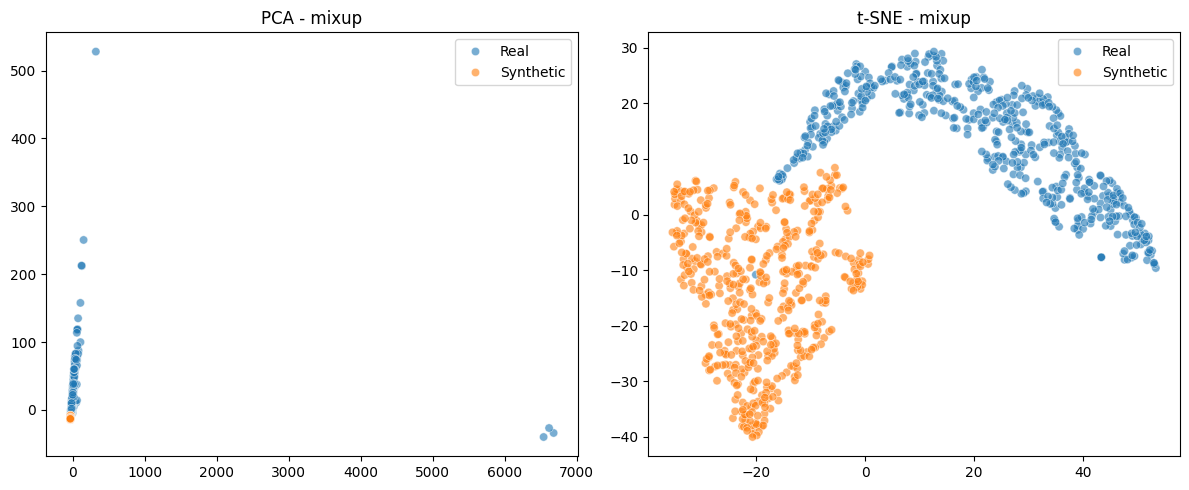


Evaluating corr...

Distribution Comparison: corr

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8179, p=0.0000 ✗ Different
  Theta   : KS=0.6736, p=0.0000 ✗ Different
  Alpha   : KS=0.6287, p=0.0000 ✗ Different
  Beta    : KS=0.6851, p=0.0000 ✗ Different
  Gamma   : KS=0.5101, p=0.0000 ✗ Different
  total_power: KS=0.9591, p=0.0000 ✗ Different

MMD Score: -30.0936

TSTR/TRTR Evaluation: corr
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5646
Difference: 0.1262


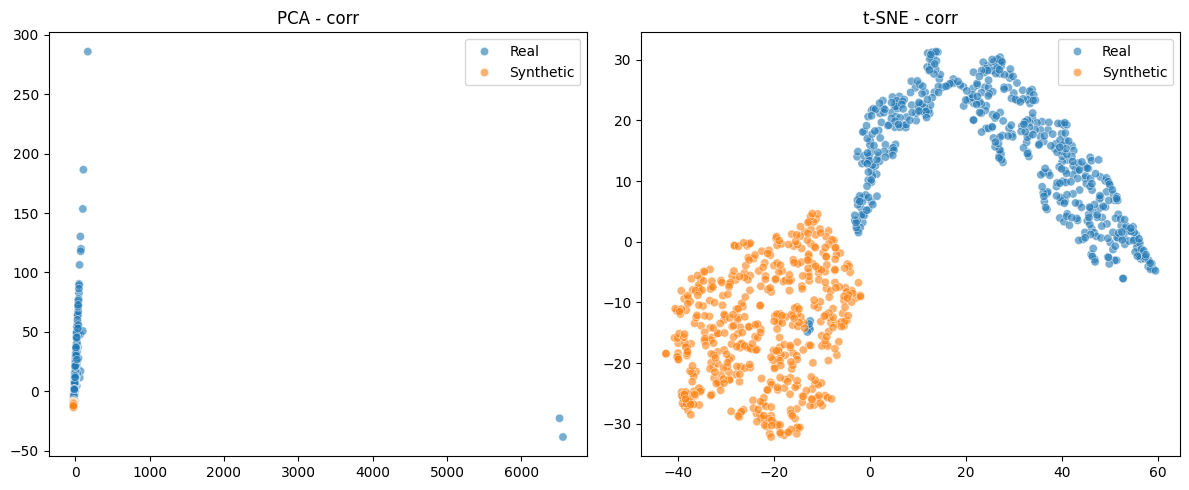


Evaluating wgangp...

Distribution Comparison: wgangp

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8388, p=0.0000 ✗ Different
  Theta   : KS=0.7540, p=0.0000 ✗ Different
  Alpha   : KS=0.7589, p=0.0000 ✗ Different
  Beta    : KS=0.7370, p=0.0000 ✗ Different
  Gamma   : KS=0.7243, p=0.0000 ✗ Different
  total_power: KS=0.9351, p=0.0000 ✗ Different

MMD Score: -34.1410

TSTR/TRTR Evaluation: wgangp
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.4821
Difference: 0.2087


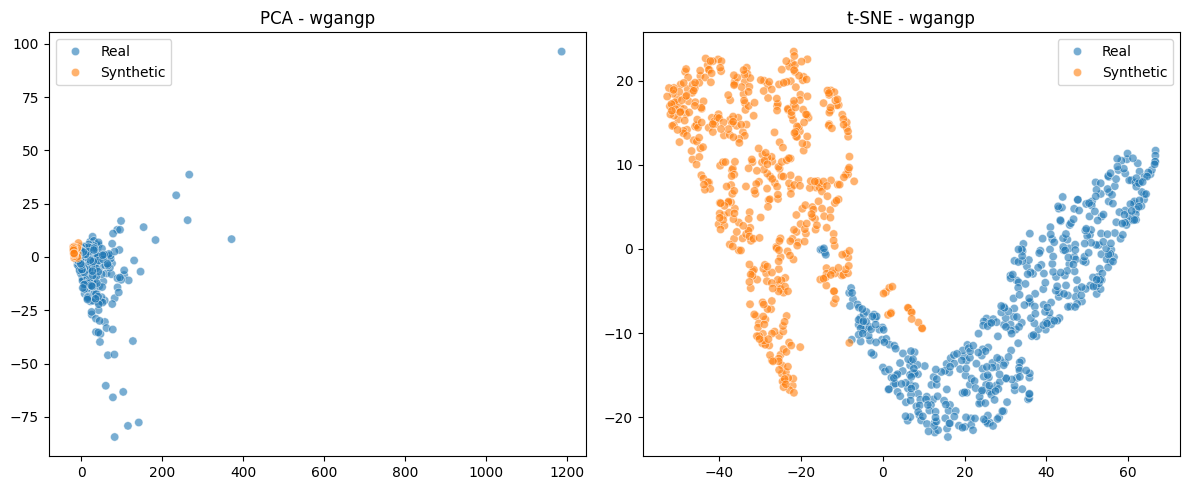


Evaluating copula...

Distribution Comparison: copula

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.7908, p=0.0000 ✗ Different
  Theta   : KS=0.7167, p=0.0000 ✗ Different
  Alpha   : KS=0.7142, p=0.0000 ✗ Different
  Beta    : KS=0.6788, p=0.0000 ✗ Different
  Gamma   : KS=0.6966, p=0.0000 ✗ Different
  total_power: KS=0.9087, p=0.0000 ✗ Different

MMD Score: -32.6924

TSTR/TRTR Evaluation: copula
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5522
Difference: 0.1385


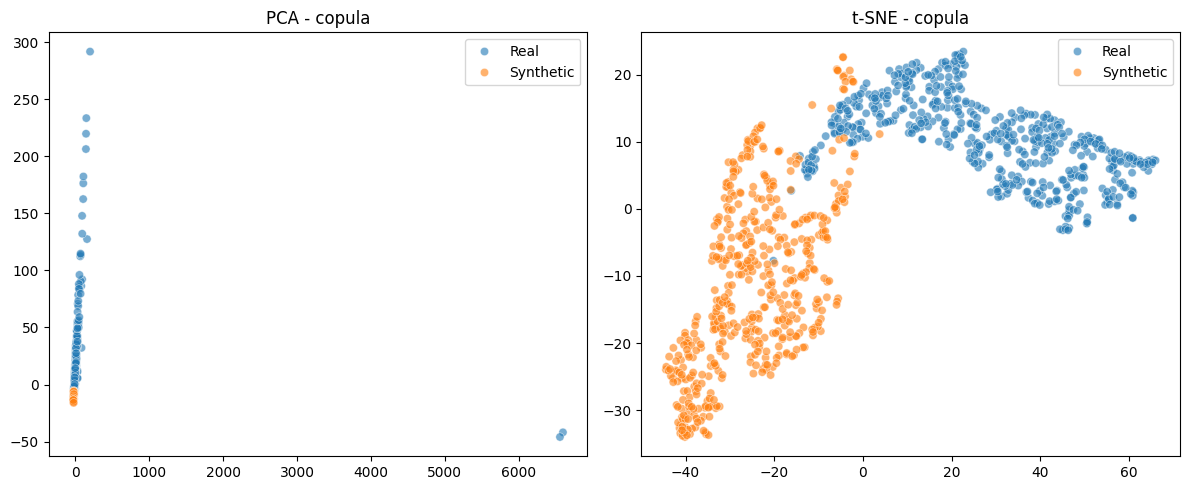


Evaluating interp...

Distribution Comparison: interp

Kolmogorov-Smirnov Test Results:
  Delta   : KS=0.8433, p=0.0000 ✗ Different
  Theta   : KS=0.7573, p=0.0000 ✗ Different
  Alpha   : KS=0.7517, p=0.0000 ✗ Different
  Beta    : KS=0.7384, p=0.0000 ✗ Different
  Gamma   : KS=0.7553, p=0.0000 ✗ Different
  total_power: KS=0.9379, p=0.0000 ✗ Different

MMD Score: -34.1917

TSTR/TRTR Evaluation: interp
TRTR Accuracy: 0.6907
TSTR Accuracy: 0.5570
Difference: 0.1337


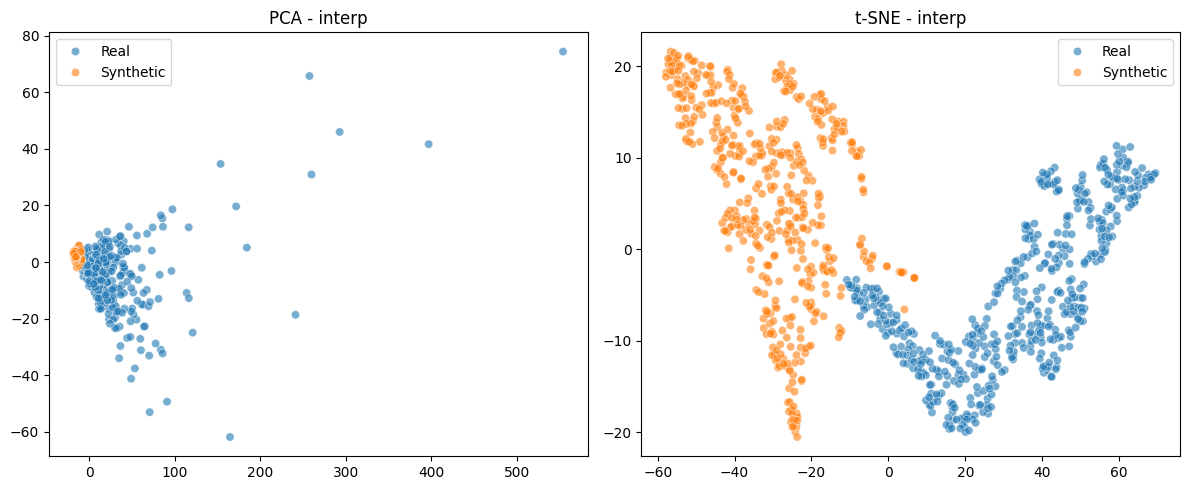


Evaluation Complete. Results saved.


In [7]:
# Load Real Data
df_real = load_real_data()
if df_real is not None:
    real_features = df_real[BAND_COLS].values
    real_labels = df_real['label'].values

    results = {}

    for model in MODEL_NAMES:
        print(f"\nEvaluating {model}...")
        df_syn = load_synthetic_data(model)
        if df_syn is None:
            continue
            
        syn_features = df_syn[BAND_COLS].values
        # Check if label column exists, otherwise we might need to handle it
        if 'label' in df_syn.columns:
            syn_labels = df_syn['label'].values
        else:
            print(f"Warning: No label column in {model} synthetic data. Skipping TSTR.")
            syn_labels = None
            
        # 1. Distributions
        ks_res, mmd = evaluate_distributions(real_features, syn_features, model)
        
        # 2. TSTR/TRTR
        tstr_res = None
        if syn_labels is not None:
            trtr, tstr = evaluate_tstr_trtr(real_features, real_labels, syn_features, syn_labels, model)
            tstr_res = {'trtr': trtr, 'tstr': tstr}
            
        # 3. Visualization
        visualize_pca_tsne(real_features, syn_features, model)
        
        results[model] = {
            'ks': ks_res,
            'mmd': mmd,
            'tstr_trtr': tstr_res
        }

    # Save results
    with open(EVAL_DIR / "evaluation_metrics.json", "w") as f:
        # Convert numpy types to python types for json serialization
        class NpEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer): return int(obj)
                if isinstance(obj, np.floating): return float(obj)
                if isinstance(obj, np.ndarray): return obj.tolist()
                return super(NpEncoder, self).default(obj)
                
        json.dump(results, f, cls=NpEncoder, indent=4)

    print("\nEvaluation Complete. Results saved.")
else:
    print("Failed to load real data.")